## DELE CA1 Part A
Jayden Yap p2112790 

### Setup

In [20]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Train test validation splits

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [22]:
def processArraysToDF(xArray,yArray,shapeTuple):
    Xdf=pd.DataFrame(xArray.squeeze().reshape(shapeTuple))
    Ydf=pd.DataFrame(yArray.squeeze())
    df=pd.concat([Xdf,Ydf],axis=1)
    df.columns=[*df.columns[:-1],'label']
    return df

In [23]:
train_data=processArraysToDF(x_train,y_train,(60000,784))
test_data=processArraysToDF(x_test,y_test,(10000,784))
print(f'Train Data shape: {train_data.shape}')
print(f'Test Data shape: {test_data.shape}')

Train Data shape: (60000, 785)
Test Data shape: (10000, 785)


Validation set

In [24]:
x_trainOG=x_train 
y_trainOG=y_train
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=10000,random_state=1) 
display(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)
#total train set 

(50000, 28, 28)

(10000, 28, 28)

(50000,)

(10000,)

### EDA 

In [25]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data['label'].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

print('TRAIN DATA:')
get_classes_distribution(train_data)
print('TEST DATA:')
get_classes_distribution(test_data)

TRAIN DATA:
Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%
TEST DATA:
Ankle Boot          :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Dress               :   1000 or 10.0%
Bag                 :   1000 or 10.0%
T-shirt/top         :   1000 or 10.0%


Check class distribution in new train data splits

In [26]:
newDF=processArraysToDF(x_train,y_train,(50000,784))
get_classes_distribution(newDF) #no longer exactly same splits due to random train test splits

Coat                :   5038 or 10.076%
Bag                 :   5029 or 10.058%
T-shirt/top         :   5019 or 10.038%
Shirt               :   5007 or 10.014000000000001%
Sandal              :   4998 or 9.995999999999999%
Dress               :   4997 or 9.994%
Sneaker             :   4988 or 9.976%
Trouser             :   4981 or 9.962%
Ankle Boot          :   4973 or 9.946000000000002%
Pullover            :   4970 or 9.94%


Visualise the classes

In [27]:
x_train_flat=x_trainOG.reshape(60000,-1)
x_trainDF=pd.DataFrame(x_train_flat)
#60000 rows (1 row per image)
#784 columns (1 column per pixel in 28 x28 image)
y_trainDF=pd.DataFrame(y_trainOG)
#10 unique labels for images
y_trainDF.columns=['Label']
df=pd.concat([y_trainDF,x_trainDF],axis=1)
df=df.sort_values(by=["Label"])
#we want to get one image from every class for visualisation (6000 per class)
df1=df.iloc[::6000,:]
df1X=df1.drop(['Label'],axis=1)
df1Y=df1['Label']

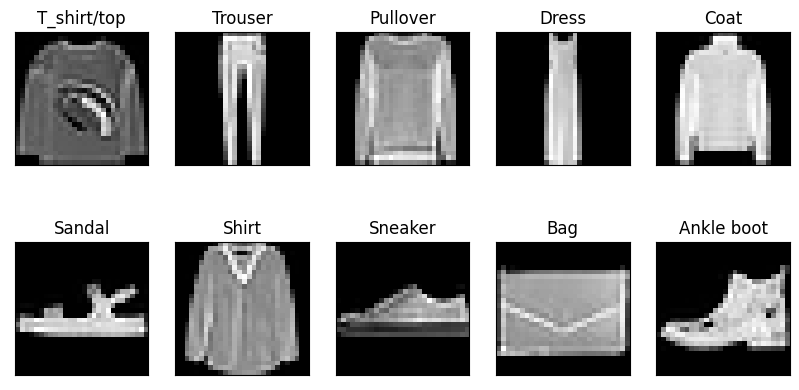

In [28]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(df1X)[i].reshape((28,28)), cmap='gray')
    label_index = int(np.array(df1Y)[i])
    plt.title(class_names[label_index])
plt.show()
#notice that coat, tshirt, pullover and shirt are very similar
#trousers and dress have similar shape too 
#sandals and sneakers have similar shape 
#we can expect these classes to get overlap in our model

### Data Augmentation (Feature Engineering)
We will make use of a model with layers of augmentation layers (like rotation and contrast randomization)
This will help us create more 'artificial' data to feed into the model and hopefully make it more generalised 

In [29]:
#function for easy visualisations
def imshow(img):
    img=img.numpy().astype('uint8').squeeze()
    plt.axis("off")
    plt.imshow(img,cmap='gray')
    plt.show()
# add a dimension as a empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

Note if running the model takes very long run this commented cell, should not take more than a minute

In [30]:
#!pip install tensorflow-gpu==2.8.3

In [31]:
modelAug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=1),
  tf.keras.layers.RandomRotation(0.2, seed=1, input_shape=[28,28,1]),
  tf.keras.layers.RandomZoom(-0.2,-0.2)
])
#apply to whole image set
augImg=modelAug(x_train,training=True)

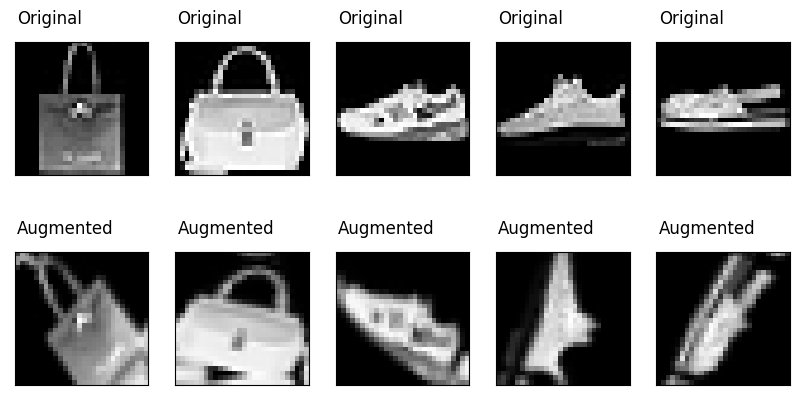

In [32]:
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.text(0,0,s='Original\n',fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    label_index = y_train[i]


n=0 #counter
for i in range(5,10):
    plt.subplot(2,5, i+1)
    plt.text(0,0,s='Augmented\n',fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augImg[n].numpy().astype('uint8').squeeze(),cmap='gray')
    label_index=y_train[n]
    n+=1
plt.show()
#now we have effectively doubled our training data from 50000 to 100000 images

Final concatenations and Sanity Checks

In [33]:
x_trainCombined=np.concatenate((x_train.squeeze(),augImg.numpy().squeeze().astype('uint8')))
#do same for y training set 
y_trainCombined=np.concatenate((y_train,y_train))
#expand dimension again
x_trainCombined = np.expand_dims(x_trainCombined, -1)
y_trainCombined = np.expand_dims(y_trainCombined, -1)
print(f'x_trainCombined final shape: {x_trainCombined.shape}')
print(f'y_trainCombined final shape: {y_trainCombined.shape}')

x_trainCombined final shape: (100000, 28, 28, 1)
y_trainCombined final shape: (100000, 1)


### Building Baseline Model 

In [34]:
def createModel(learningRate):
      tf.keras.backend.clear_session()
      model = tf.keras.models.Sequential()
      #layers
      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
      model.add(tf.keras.layers.Dropout(0.4))

      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(tf.keras.layers.Dropout(0.4))

      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
      model.add(tf.keras.layers.Dropout(0.4))

      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(256))
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(128))
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.Dropout(0.4))
      model.add(tf.keras.layers.Dense(10))
      #output layer
      model.add(tf.keras.layers.Activation('softmax'))
      model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate, ),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
      return model

In [35]:
model1=createModel(0.001) #learning rate 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

#### Fit on Original Data

In [40]:
earlyStopper = EarlyStopping(monitor = 'val_loss', patience = 12)
#batch size: 1024 ----> 48 steps
#batch size: 512  ----> 96 steps 
# steps=samples/batchSize
history1=model1.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=75,
    batch_size=1024,
    steps_per_epoch=48,
    validation_data=(x_valid.astype(np.float32), y_valid.astype(np.float32)),
    validation_freq=1,
    callbacks=earlyStopper
)
#model1.save_weights('./weights/weights1.h5', overwrite=True)

Epoch 1/75
48/48 [==============================] - 8s 51ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.5947 - val_loss: 1.1359 - val_sparse_categorical_accuracy: 0.6752
Epoch 2/75
48/48 [==============================] - 2s 39ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.7732 - val_loss: 1.1889 - val_sparse_categorical_accuracy: 0.5531
Epoch 3/75
48/48 [==============================] - 2s 39ms/step - loss: 0.5092 - sparse_categorical_accuracy: 0.8142 - val_loss: 1.2627 - val_sparse_categorical_accuracy: 0.6043
Epoch 4/75
48/48 [==============================] - 2s 40ms/step - loss: 0.4487 - sparse_categorical_accuracy: 0.8388 - val_loss: 1.4500 - val_sparse_categorical_accuracy: 0.5161
Epoch 5/75
48/48 [==============================] - 2s 39ms/step - loss: 0.4045 - sparse_categorical_accuracy: 0.8536 - val_loss: 1.4902 - val_sparse_categorical_accuracy: 0.4552
Epoch 6/75
48/48 [==============================] - 2s 39ms/step - loss: 0.3678 - sparse_categorical_accu

In [41]:
model1.evaluate(x_test,y_test)           

313/313 [==============================] - 1s 4ms/step - loss: 0.2187 - sparse_categorical_accuracy: 0.9286


[0.21872234344482422, 0.928600013256073]

Visualising accuracy and loss over time

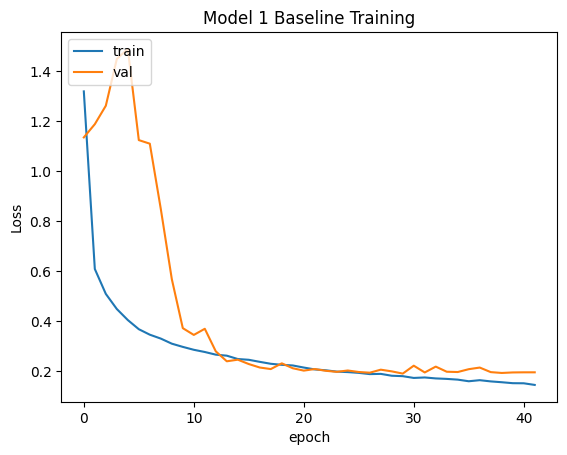

In [42]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 Baseline Training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

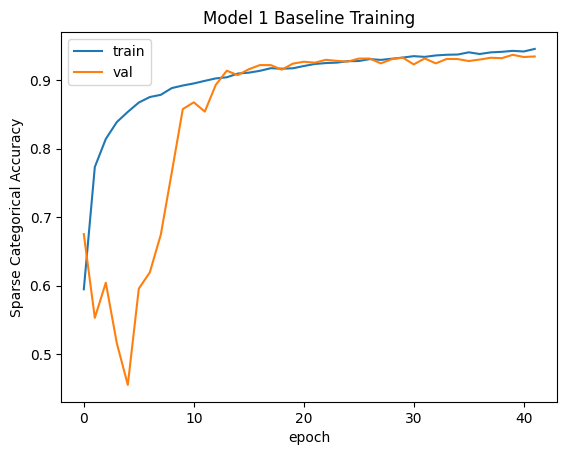

In [43]:
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history1.history['val_sparse_categorical_accuracy'])
plt.title('Model 1 Baseline Training')
plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### TO DO: PLOT CLASSIFICATION REPORT 

#### Results from baseline:
Some overfitting encountered near the end of training, we will increase dropout factor to combat this.
Accuracy of 92% is quite decent, let's see if we can push the limits with methods like Augmented Data + Hyperparameter tuning 

### Improving Model

#### Try Fitting on Augmented data
Our augmented data has twice the amount of data which can lead to less overfitting, and more training data can also help with accuracy

In [44]:
def createAugModel(learningRate):
      tf.keras.backend.clear_session()
      model = tf.keras.models.Sequential()
      #layers
      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
      model.add(tf.keras.layers.Dropout(0.35))

      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(tf.keras.layers.Dropout(0.35))

      model.add(tf.keras.layers.BatchNormalization(input_shape=x_trainCombined.shape[1:]))
      model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
      model.add(tf.keras.layers.Dropout(0.35))

      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(256))
      model.add(tf.keras.layers.Activation('relu'))
      model.add(tf.keras.layers.Dropout(0.35))
      
      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(128))
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(64))
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.Dense(10))
      model.add(tf.keras.layers.Activation('softmax'))
      model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate, ),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
      return model

In [45]:
model2=createAugModel(0.001) #learning rate 
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [46]:
earlyStopper = EarlyStopping(monitor = 'val_loss', patience = 10)
#1024 batch size ---> 97 steps 
#512 batch size ---> 195 steps 
#256 batch size -> 390 steps
history2=model2.fit(
    x_trainCombined.astype(np.float32), y_trainCombined.astype(np.float32),
    epochs=100,
    batch_size=512,
    steps_per_epoch=195,
    validation_data=(x_valid.astype(np.float32), y_valid.astype(np.float32)),
    validation_freq=1,
    callbacks=earlyStopper
)
#model.save_weights('./weights/weights1.h5', overwrite=True)

Epoch 1/100
195/195 [==============================] - 5s 24ms/step - loss: 1.1201 - sparse_categorical_accuracy: 0.5820 - val_loss: 2.8665 - val_sparse_categorical_accuracy: 0.2006
Epoch 2/100
195/195 [==============================] - 4s 22ms/step - loss: 0.7870 - sparse_categorical_accuracy: 0.7057 - val_loss: 2.0400 - val_sparse_categorical_accuracy: 0.3372
Epoch 3/100
195/195 [==============================] - 4s 22ms/step - loss: 0.6783 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.4493 - val_sparse_categorical_accuracy: 0.8496
Epoch 4/100
195/195 [==============================] - 4s 22ms/step - loss: 0.6138 - sparse_categorical_accuracy: 0.7745 - val_loss: 0.3394 - val_sparse_categorical_accuracy: 0.8800
Epoch 5/100
195/195 [==============================] - 4s 22ms/step - loss: 0.5695 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.3300 - val_sparse_categorical_accuracy: 0.8801
Epoch 6/100
195/195 [==============================] - 4s 22ms/step - loss: 0.5352 - spars

In [47]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9242


[0.20719236135482788, 0.9241999983787537]

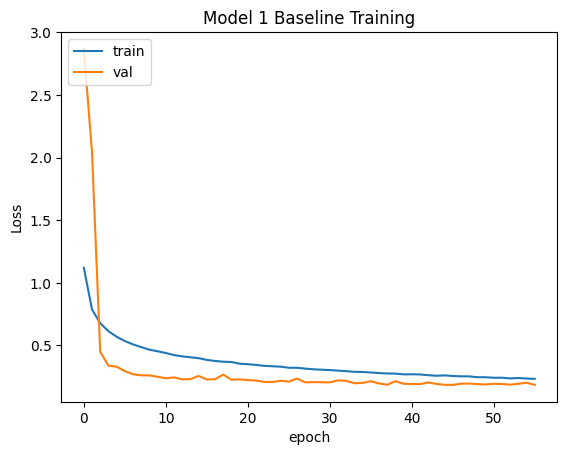

In [50]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 1 Baseline Training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

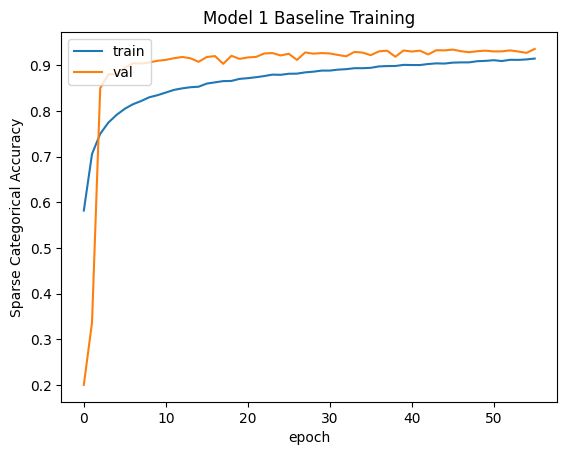

In [48]:
plt.plot(history2.history['sparse_categorical_accuracy'])
plt.plot(history2.history['val_sparse_categorical_accuracy'])
plt.title('Model 1 Baseline Training')
plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()